In [20]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
!pip3 install numpy

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import numpy as np
import pickle
from scipy.ndimage import binary_dilation
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import random as rd
from matplotlib.colors import BoundaryNorm
import scipy
from tools import DataWrapper,load_file, load_analysis_result, plot_analysis_result, CAMERA_PARAM, calculate_energy,analyse_dataset,triangle_kernel
plt.rcParams['figure.figsize'] = [20, 5]
%matplotlib inline

c:\Users\Thomas\Programming\msthesis\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DIR = os.path.abspath('')
HEATMAP_DIR = os.path.join(DIR, 'data','graphes')
PICTURES_DIR = os.path.join(DIR, 'data','images')


In [24]:
BACKGROUND_FILE = os.path.join(DIR,"background.doppler")
FILE_COUNT_TO_LOAD = 1000


timestamps_to_load = list([".".join(f.split(".")[:2]) for f in os.listdir(HEATMAP_DIR) if "doppler" in f])
timestamps_to_load = timestamps_to_load[0:min(FILE_COUNT_TO_LOAD,len(timestamps_to_load))]




dataWrapper = DataWrapper(HEATMAP_DIR, PICTURES_DIR, timestamps_to_load, picture_name_prefix="0", picture_extension_suffix="jpeg", heatmap_extension_suffix="doppler", heatmap_name_prefix="")



Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Loading picture data: 100%|██████████| 1000/1000 [00:07<00:00, 129.92it/s]


In [25]:
dataWrapper.set_background_data(BACKGROUND_FILE)

In [26]:
class Solution:
    def numIslands(self, grid) -> int:
        m = len(grid)
        n = len(grid[0])
        result = 0
        index_list = []
        shape_list = []
        for i in range(m):
            for j in range(n):
                if grid[i][j] == 1:
                    new_shape = []
                    result += 1
                    index_list.append([i, j])
                    
                    self.waterLands(grid, i, j, new_shape)
                    shape_list.append(list(new_shape))
        return result, index_list, shape_list
        
    
    #given the grid and start point, submerge the adjacent land
    def waterLands(self, grid, i, j,new_shape):
        m = len(grid)
        n = len(grid[0])
        grid[i][j] = 0
        new_shape.append([i,j])
        queue = [[i, j]]
        x_dir = [0,0,1,-1]
        y_dir = [1,-1,0,0]
        
        while queue:
            curr = queue.pop(0)
            cx = curr[0]
            cy = curr[1]
            
            for i in range(4):
                nx = cx + x_dir[i]
                ny = cy + y_dir[i]
                
                if nx >= 0 and nx < m and ny >= 0 and ny < n and grid[nx][ny] == 1:
                    queue.append([nx, ny])
                    grid[nx][ny] = 0
                    new_shape.append([nx,ny])
def energy(data):
    return np.sum(np.abs(data)**2)

def do_analysis(index):
    data = np.array(dataWrapper.heatmap_data[index])
    f_data = dataWrapper.filter(data)
    
    cfar,_,spotted = dataWrapper.CFAR_loaded(f_data)
    number_of_vehicles, pos, shape_list = Solution().numIslands(spotted)
    real_pos = []
    for shape in shape_list:
        real_pos.append(getPositionFromShapeAndData(shape, f_data))
    print(f"{number_of_vehicles} vehicles found. At positions {real_pos}")
    
    dataWrapper.plot_CFAR(index)
    
def getPositionFromShapeAndData(shape, data):
    """TODO: Calculate the incertitude

    Args:
        shape_list (_type_): _description_
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    most_energetic = shape[0]
    top_energy = data[most_energetic[0]][most_energetic[1]]
    
    for pixel_pos in shape:
        if data[pixel_pos[0]][pixel_pos[1]] > top_energy:
            most_energetic = pixel_pos
            top_energy = data[pixel_pos[0]][pixel_pos[1]]
    return most_energetic

In [27]:
sample_count = 3
sample_index = rd.sample(range(len(timestamps_to_load)), sample_count)

8.47E+11


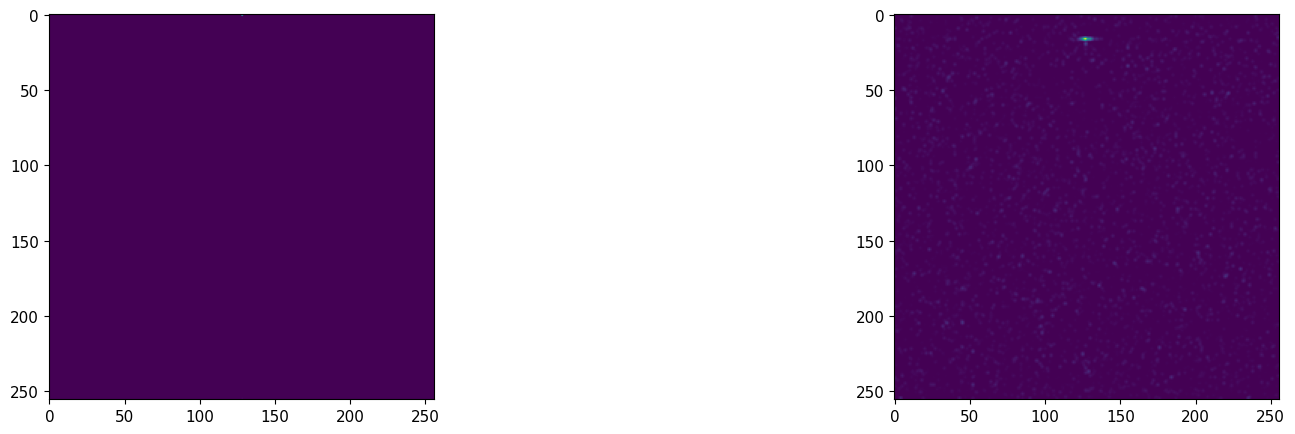

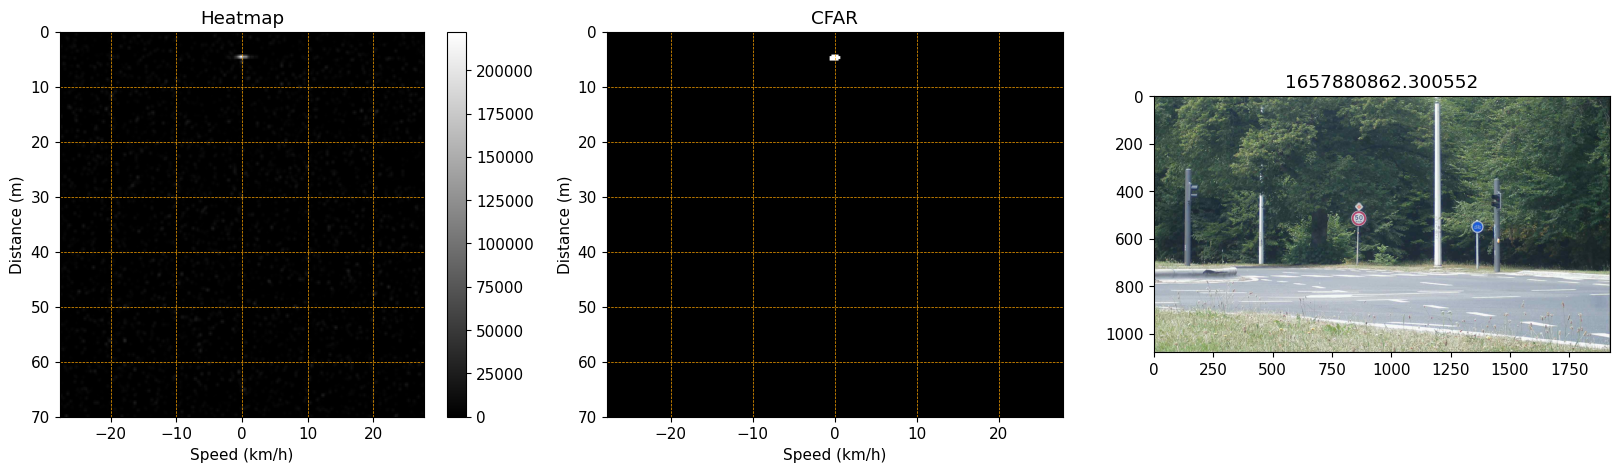

2.39E+12


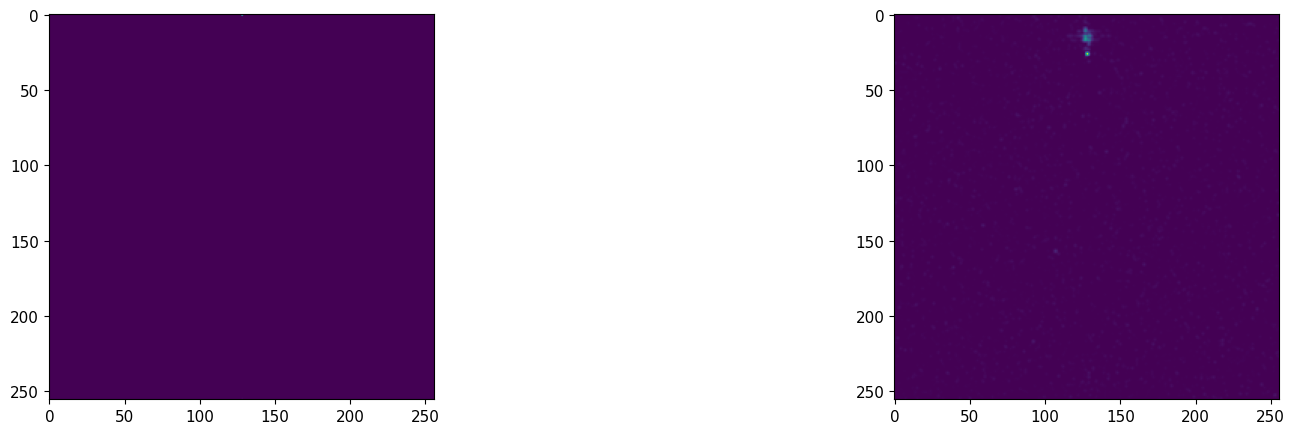

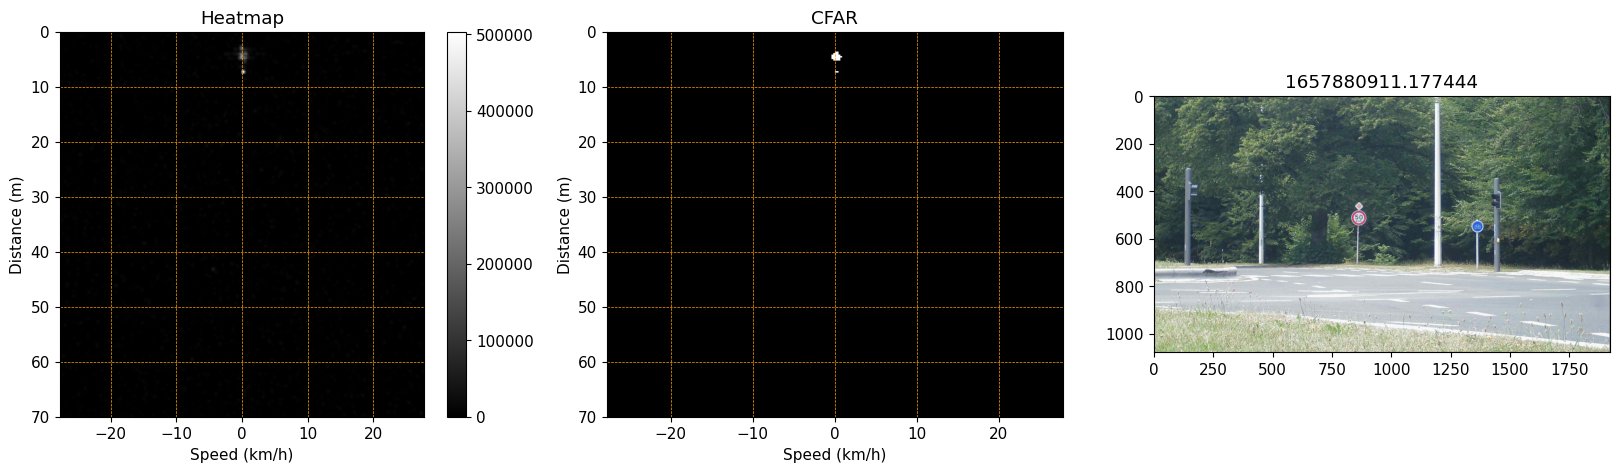

9.84E+11


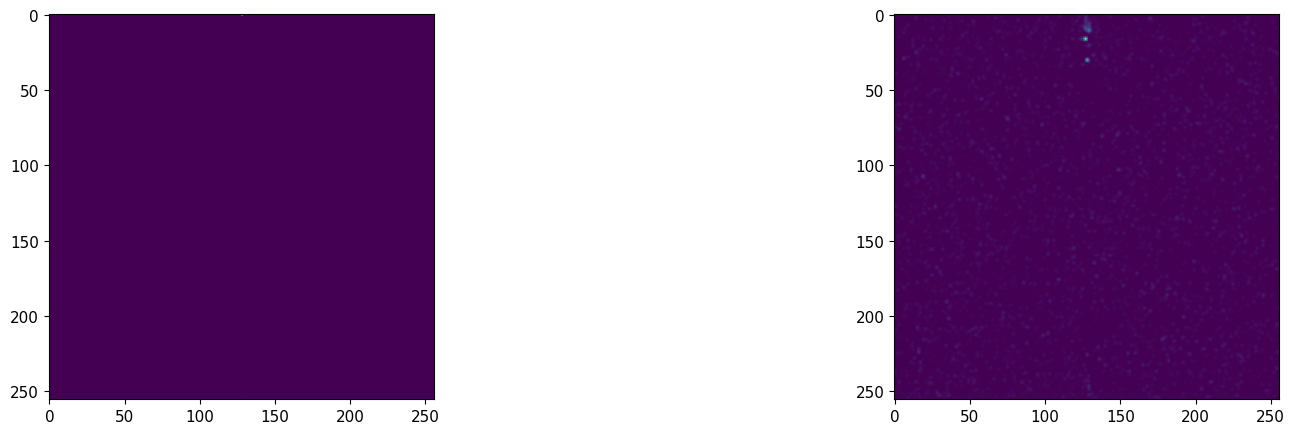

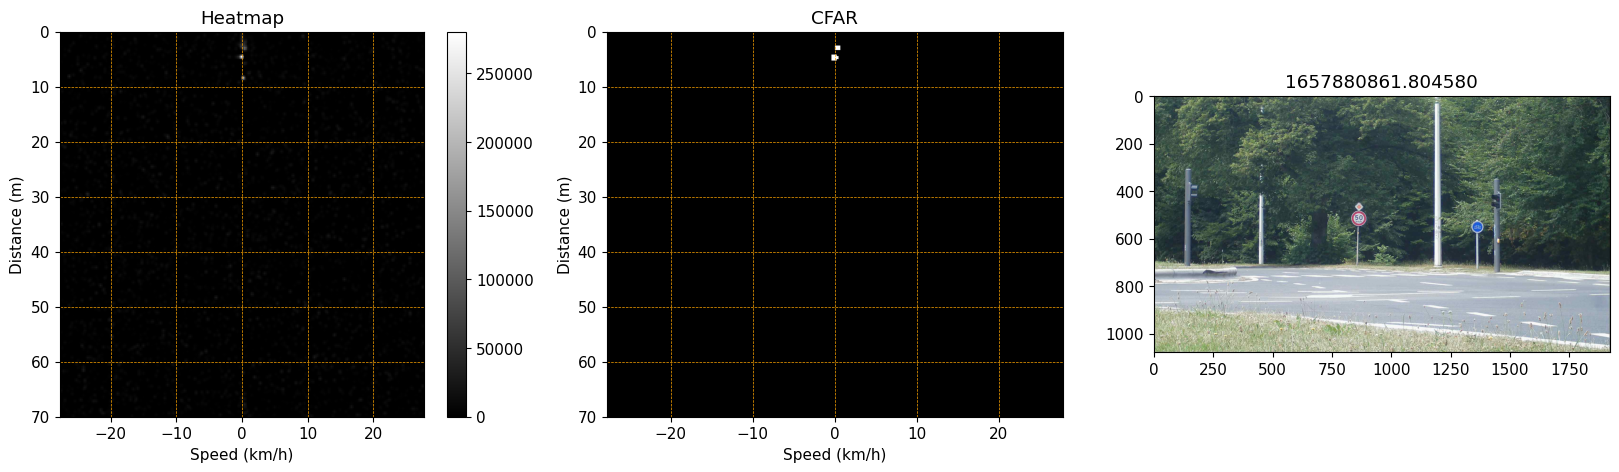

In [28]:
for i in sample_index:
    heatmap_data = dataWrapper.heatmap_data[i]
    filtered_data = dataWrapper.filter(heatmap_data)

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(heatmap_data)
    plt.subplot(1,2,2)
    plt.imshow(filtered_data)
    print(f"{energy(filtered_data):.2E}")

    
    dataWrapper.plot_CFAR(i)

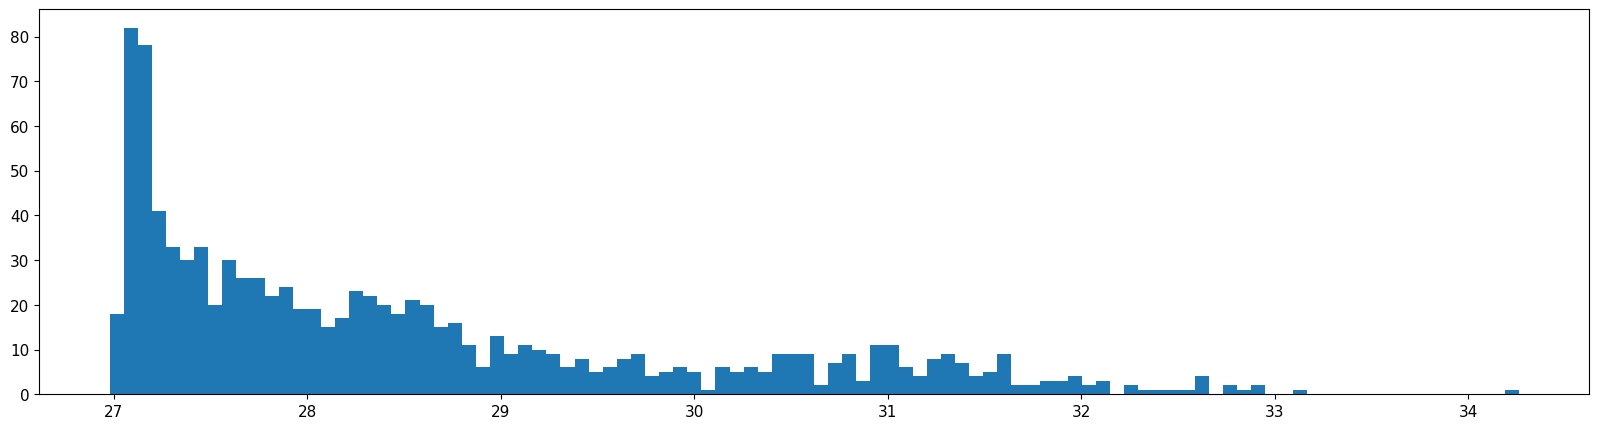

In [29]:
# Plot histogram of energy

energyList = []
HIST_SAMPLE_COUNT = min(1000,len(timestamps_to_load))

S = rd.sample(range(len(timestamps_to_load)),HIST_SAMPLE_COUNT)



for i in S:
    heatmap_data = dataWrapper.heatmap_data[i]
    filtered_data = dataWrapper.filter(heatmap_data)
    ener = np.log(int(energy(filtered_data))+1)
    energyList.append(ener)

plt.figure()
plt.hist(energyList, bins=100)
plt.show()

1 vehicles found. At positions [[16, 129]]


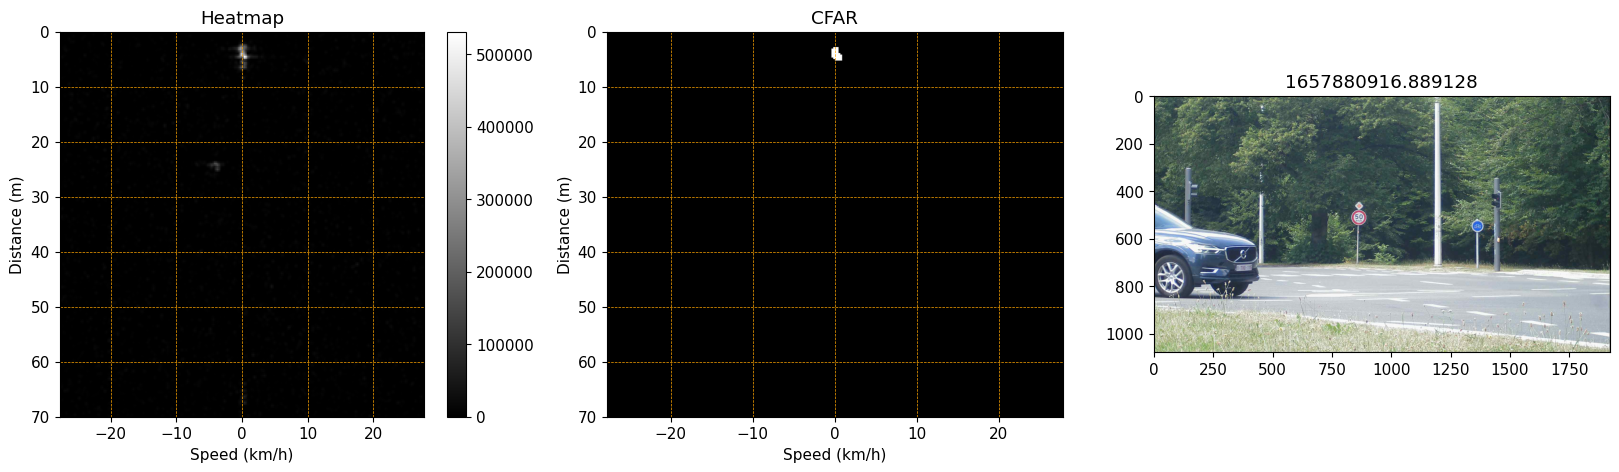

1 vehicles found. At positions [[82, 127]]


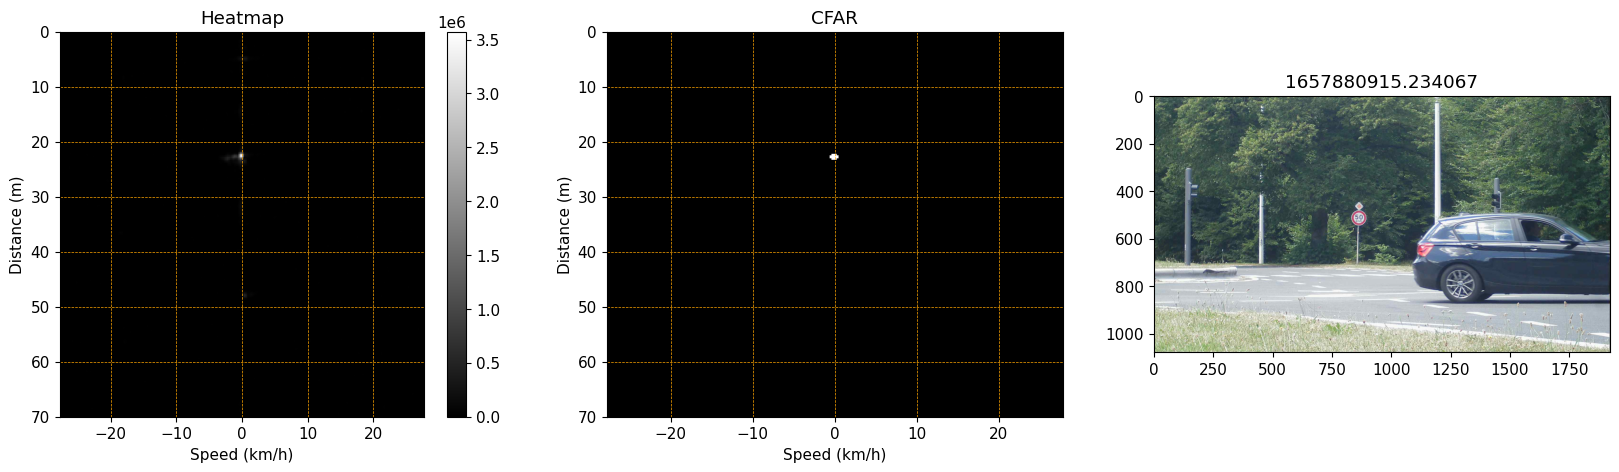

1 vehicles found. At positions [[48, 133]]


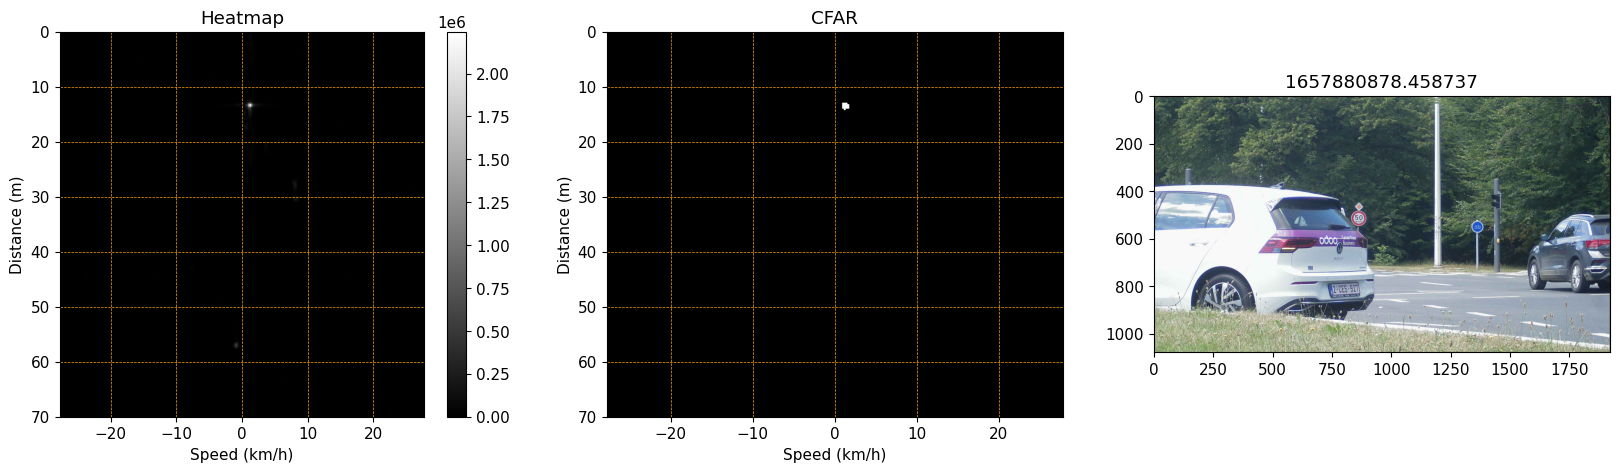

1 vehicles found. At positions [[80, 130]]


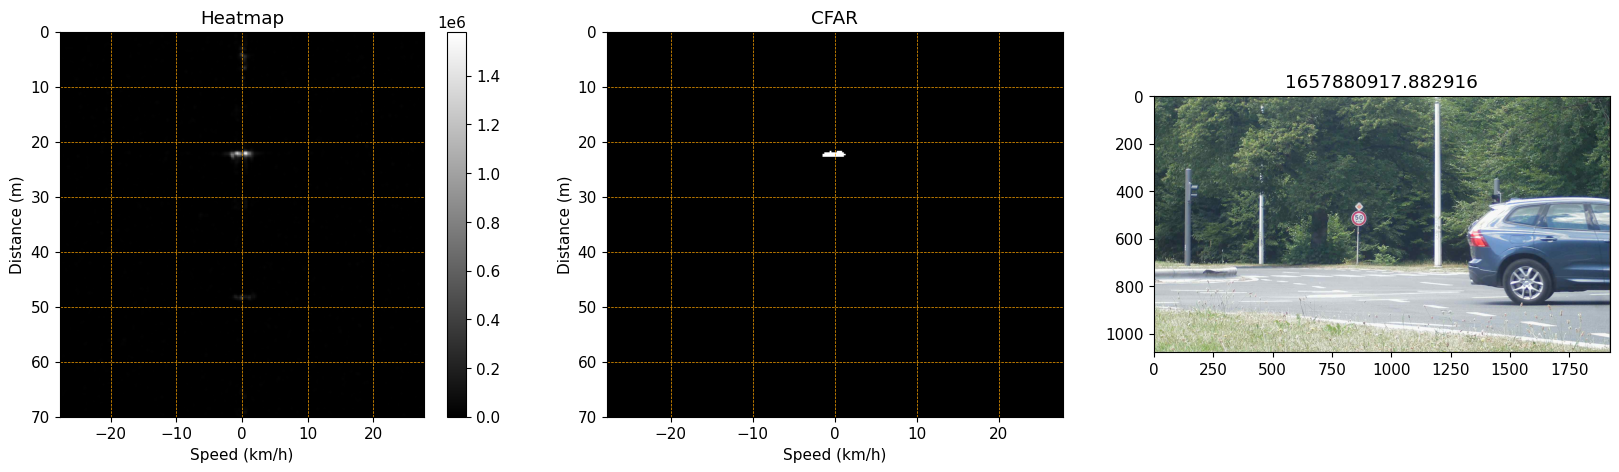

3 vehicles found. At positions [[56, 132], [95, 178], [159, 175]]


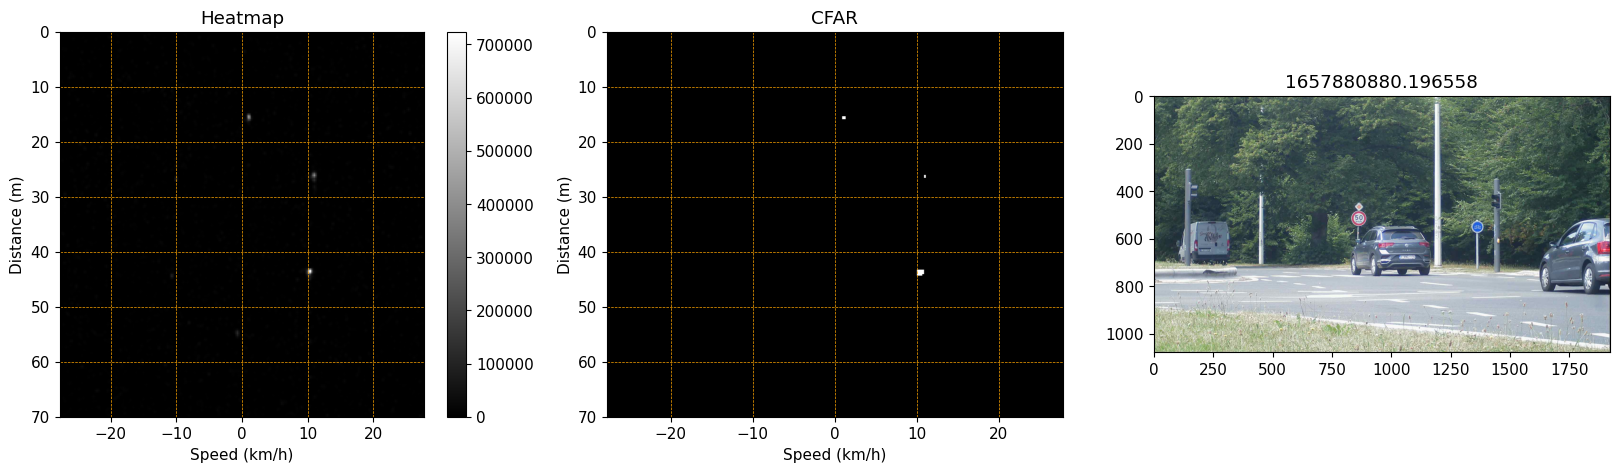

1 vehicles found. At positions [[47, 136]]


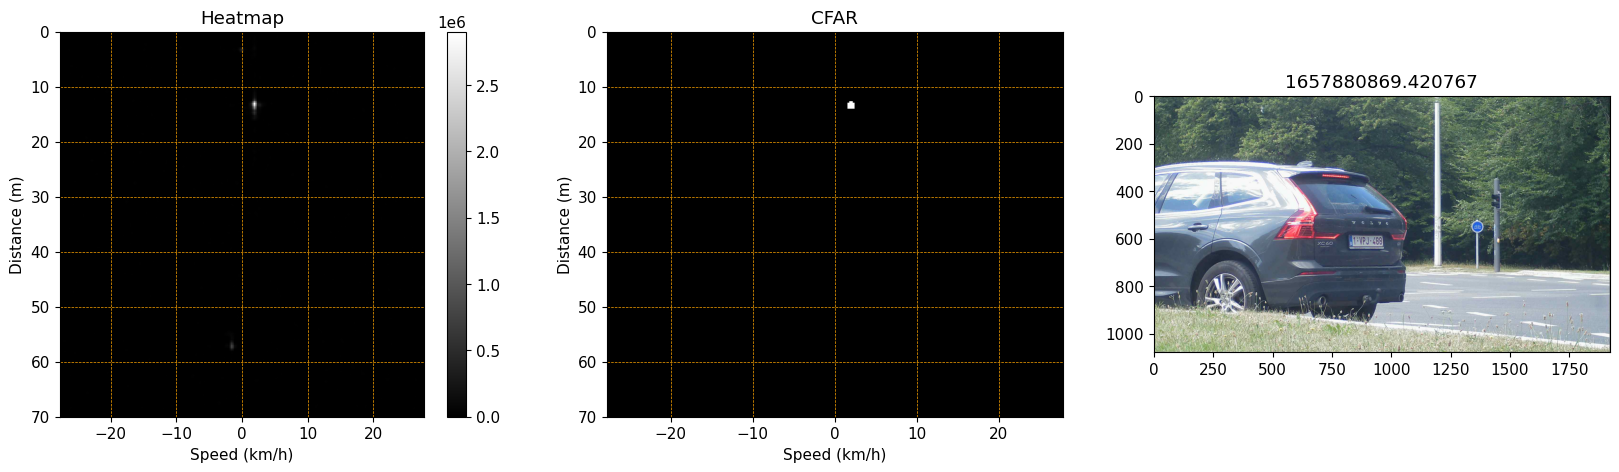

2 vehicles found. At positions [[41, 130], [56, 131]]


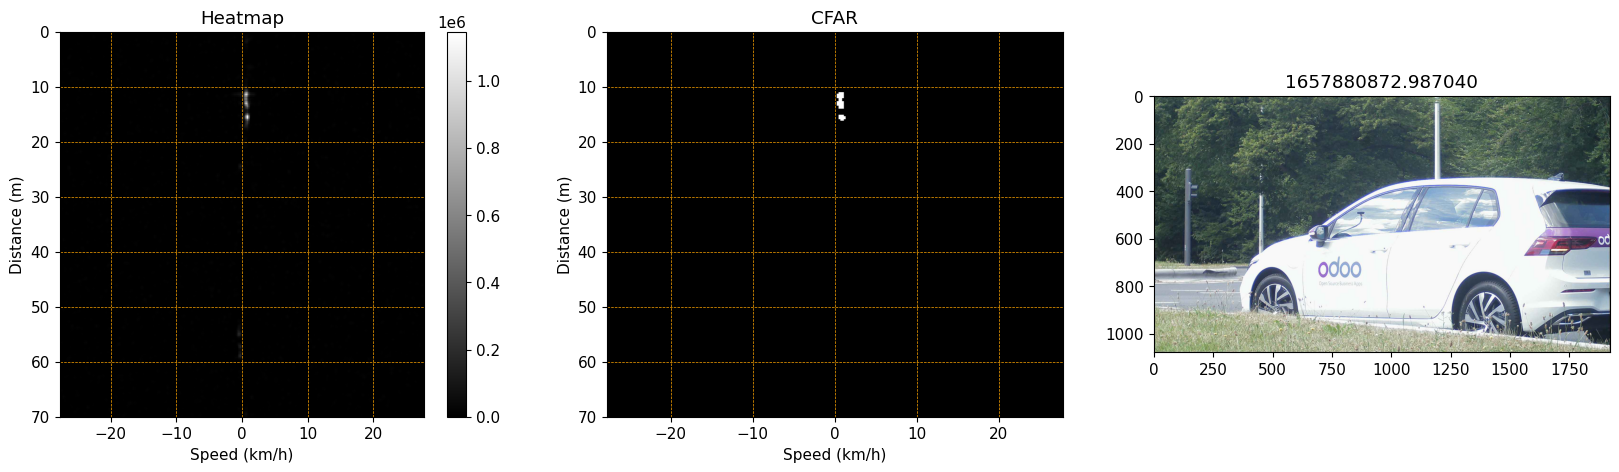

1 vehicles found. At positions [[142, 179]]


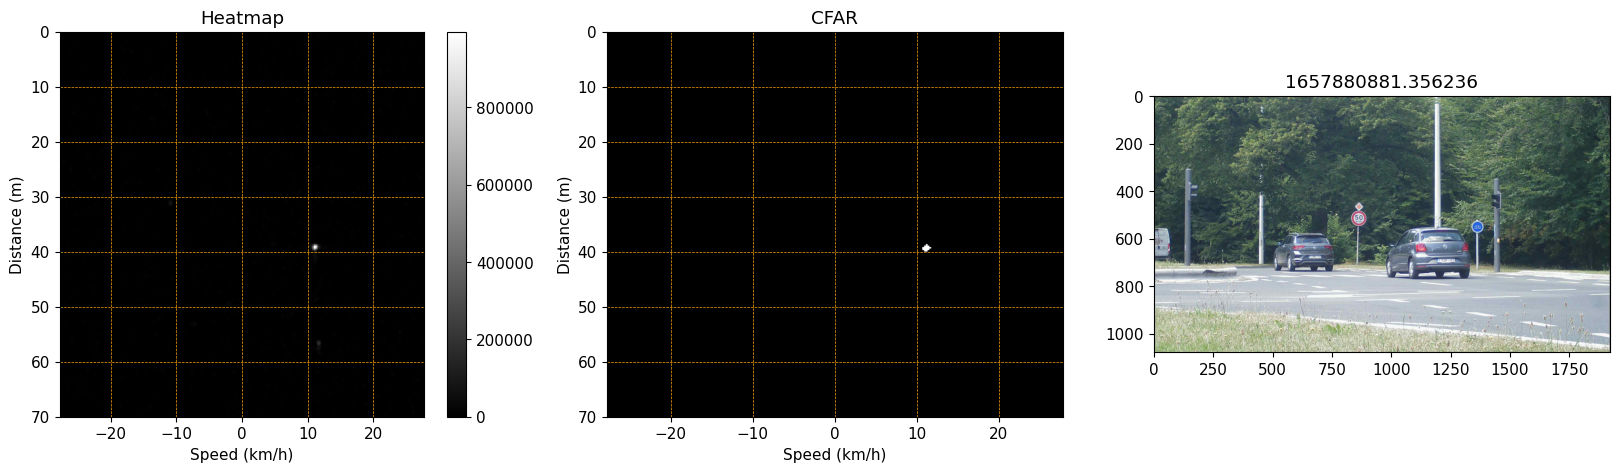

2 vehicles found. At positions [[115, 178], [178, 178]]


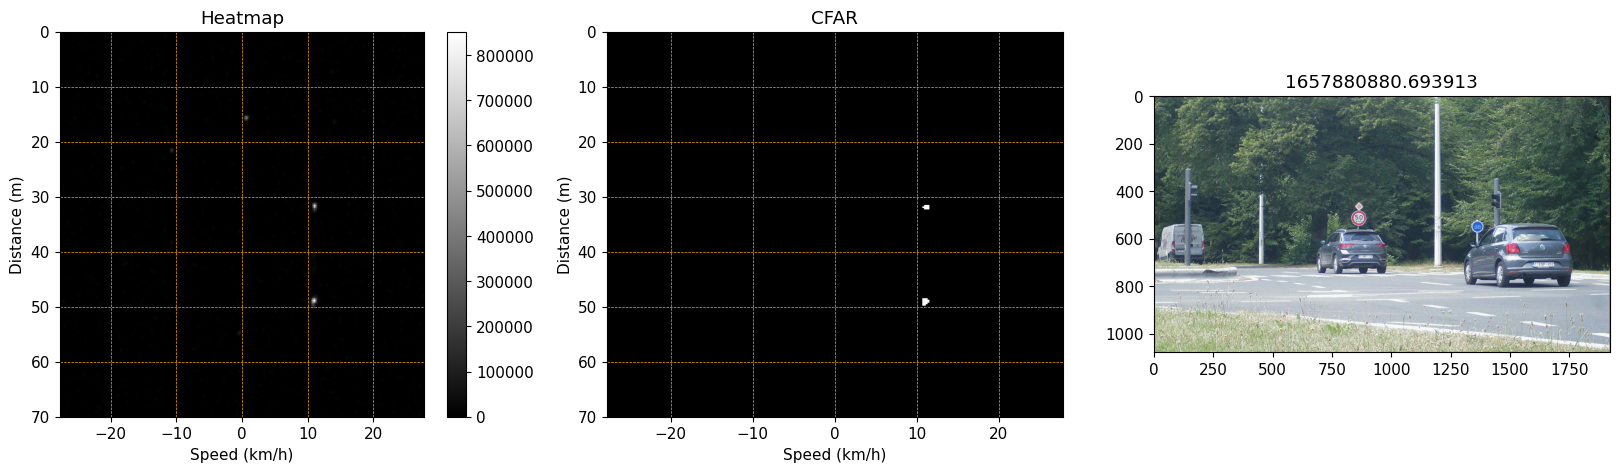

1 vehicles found. At positions [[45, 130]]


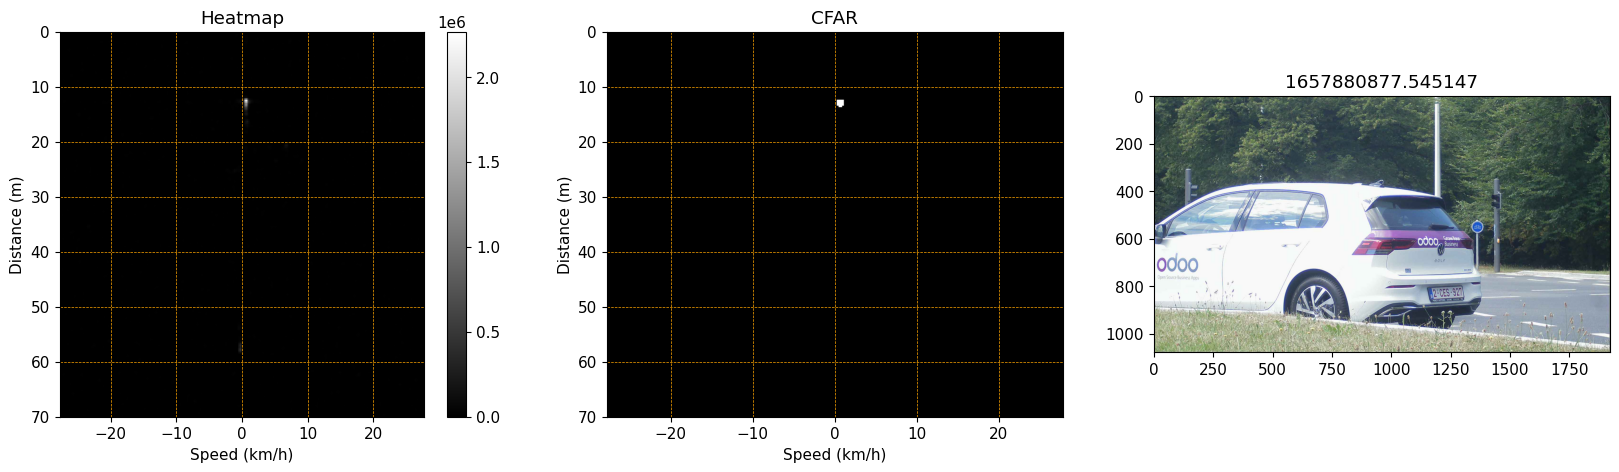

2 vehicles found. At positions [[14, 129], [106, 124]]


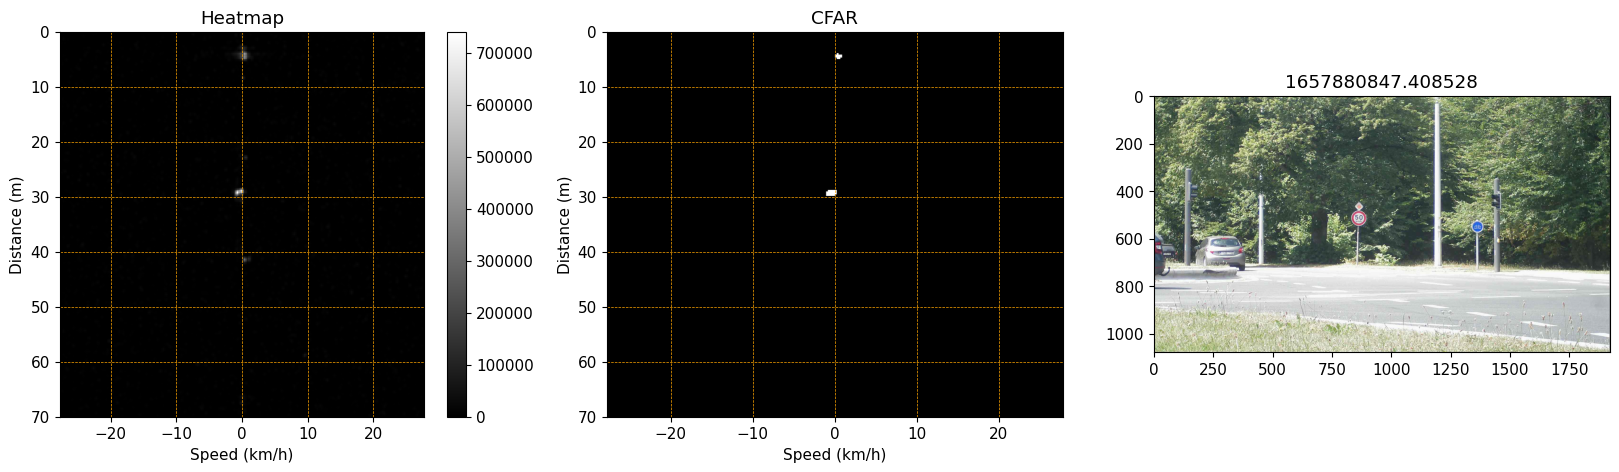

1 vehicles found. At positions [[131, 158]]


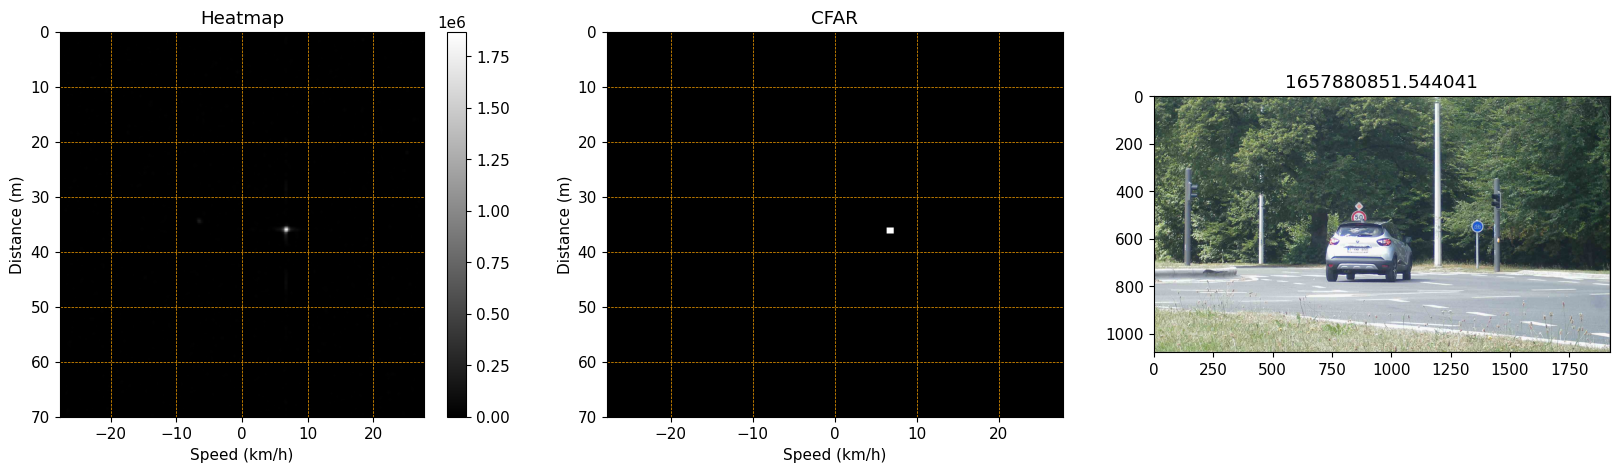

In [30]:
HIST_SAMPLE_COUNT = min(50,len(timestamps_to_load))

S = rd.sample(range(len(timestamps_to_load)),HIST_SAMPLE_COUNT)



for i in S:
    heatmap_data = dataWrapper.heatmap_data[i]
    filtered_data = dataWrapper.filter(heatmap_data)
    ener = np.log(int(energy(filtered_data))+1)
    if ener > 29:
        do_analysis(i)
        

In [31]:
# MEAN_PATH = os.path.join(DIR,"mean_heatmap.doppler")
# dataWrapper.calculate_heatmap_mean()
# dataWrapper.save_mean_heatmap_data(MEAN_PATH)

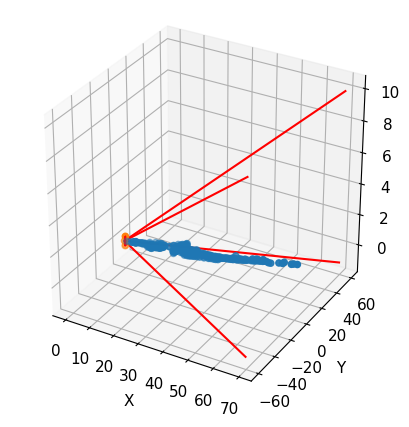

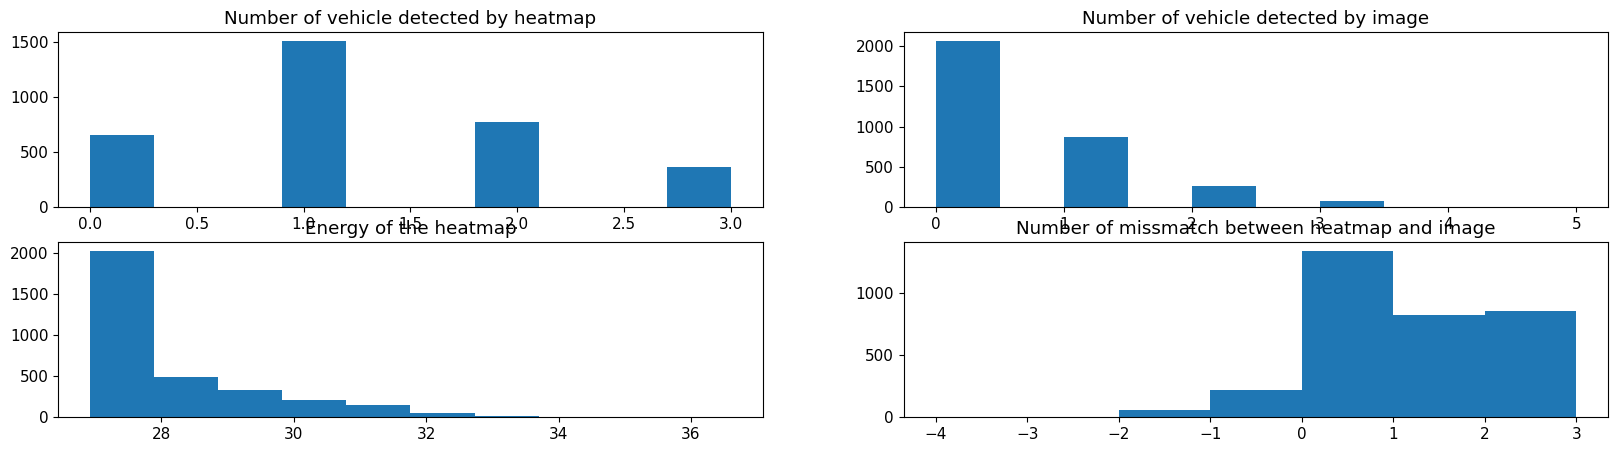

In [32]:
PATH_ANALYSIS = os.path.join(DIR,"dataset_analysis_save","analysis_3")

heatmap_data, image_data, energy, pos_list,missmatch = load_analysis_result(PATH_ANALYSIS)

plot_analysis_result(heatmap_data, image_data, energy, pos_list,missmatch, CAMERA_PARAM)


# Study of the filter influance


To select the best filter we define the following score:
minimizing the number of missmatch.

In [3]:
filter_list = []
filter_name=[]
def original_filter(self,data):
    """Main function to modify the filtering of the heatmap data. You may overwrite this function.

    Args:
        data (np.array): Data to filter

    Returns:
        np.array: Filtered Data
    """
    if self.heatmap_mean is None:
        self.calculate_heatmap_mean()
    data = data - self.background_data
    data = data - self.heatmap_mean

    data = np.maximum(data, 0)
    
    kernel = triangle_kernel(3)
    filtred_bg = scipy.signal.convolve2d(self.background_data, kernel, mode='same')
    
    
    data = scipy.signal.convolve2d(data, kernel, mode='same')
    
    # data = data - filtred_bg
    return data

filter_list.append(original_filter)
filter_name.append("original_filter")
def filter_triangle5(self,data):
    if self.heatmap_mean is None:
        self.calculate_heatmap_mean()
    data = data - self.background_data
    data = data - self.heatmap_mean

    data = np.maximum(data, 0)
    
    kernel = triangle_kernel(5)
    filtred_bg = scipy.signal.convolve2d(self.background_data, kernel, mode='same')
    
    
    data = scipy.signal.convolve2d(data, kernel, mode='same')
    
    # data = data - filtred_bg
    return data

filter_list.append(filter_triangle5)
filter_name.append("filter_triangle5")
def filter_triangle7(self,data):
    if self.heatmap_mean is None:
        self.calculate_heatmap_mean()
    data = data - self.background_data
    data = data - self.heatmap_mean

    data = np.maximum(data, 0)
    
    kernel = triangle_kernel(7)
    filtred_bg = scipy.signal.convolve2d(self.background_data, kernel, mode='same')
    
    
    data = scipy.signal.convolve2d(data, kernel, mode='same')
    
    # data = data - filtred_bg
    return data
filter_list.append(filter_triangle7)
filter_name.append("filter_triangle7")
res_list = []
for custom_filter in filter_list:
    pos_list,missmatch_count_heatmap_image,energy_heatmap,detected_vehicle_heatmap,detected_vehicle_image = analyse_dataset(BATCH_SIZE = 500,FILE_COUNT_TO_LOAD = 10000,FILE_DIRECTORY = DIR,customfilter=custom_filter)
    res_list.append([pos_list,missmatch_count_heatmap_image,energy_heatmap,detected_vehicle_heatmap,detected_vehicle_image])
 

Batch:   0%|          | 0/7 [00:00<?, ?it/s]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  14%|█▍        | 1/7 [00:54<05:26, 54.46s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  29%|██▊       | 2/7 [01:51<04:38, 55.69s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  43%|████▎     | 3/7 [02:48<03:46, 56.67s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 

1.8910411622276029


Batch:   0%|          | 0/7 [00:00<?, ?it/s]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  14%|█▍        | 1/7 [00:53<05:20, 53.47s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  29%|██▊       | 2/7 [01:48<04:32, 54.58s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  43%|████▎     | 3/7 [02:43<03:37, 54.44s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 

1.8568401937046004


Batch:   0%|          | 0/7 [00:00<?, ?it/s]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  14%|█▍        | 1/7 [00:56<05:37, 56.17s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  29%|██▊       | 2/7 [01:53<04:43, 56.72s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  43%|████▎     | 3/7 [02:49<03:46, 56.63s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 

1.814769975786925


In [5]:
for i,custom_filter in enumerate(filter_name):
    dirname = os.path.join(DIR,"dataset_analysis_save",f"analysis_{4+i}")
    heatmap_data, image_data, energy, pos_list,missmatch = load_analysis_result(path=dirname)
    loss = np.mean((missmatch_count_heatmap_image)**2)
    
    print(f"{custom_filter}")
    print(f"\tloss: {loss}")
    print(f"\tmean energy: {np.mean(energy_heatmap)}")
    print(f"\tmean missmatch: {np.mean(missmatch_count_heatmap_image)}")
    print(f"\tmean detected vehicle heatmap: {np.mean(detected_vehicle_heatmap)}")
    
    

original_filter
	loss: 1.814769975786925
	mean energy: 7003634554619.002
	mean missmatch: 0.7203389830508474
	mean detected vehicle heatmap: 1.2339588377723971
filter_triangle5
	loss: 1.814769975786925
	mean energy: 7003634554619.002
	mean missmatch: 0.7203389830508474
	mean detected vehicle heatmap: 1.2339588377723971
filter_triangle7
	loss: 1.814769975786925
	mean energy: 7003634554619.002
	mean missmatch: 0.7203389830508474
	mean detected vehicle heatmap: 1.2339588377723971


We can see that the triangle size doesnt improve performance. We will keep it at 3 to limit the energy spreading.

In [4]:
for cfar_threshold in range(20,100,10):
    pos_list,missmatch_count_heatmap_image,energy_heatmap,detected_vehicle_heatmap,detected_vehicle_image = analyse_dataset(BATCH_SIZE = 500,FILE_COUNT_TO_LOAD = 1000,FILE_DIRECTORY = DIR,cfar_threshold=cfar_threshold)
     

Batch:   0%|          | 0/2 [00:00<?, ?it/s]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  50%|█████     | 1/2 [00:53<00:53, 53.84s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:   0%|          | 0/2 [00:00<?, ?it/s]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  50%|█████     | 1/2 [00:52<00:52, 52.46s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3

In [12]:

for i, cfar_threshold in enumerate(range(20,100,10)):
    dirname = os.path.join(DIR,"dataset_analysis_save",f"analysis_{7+i}")

    heatmap_data, image_data, energy, pos_list,missmatch = load_analysis_result(path=dirname)
    loss = np.mean((missmatch)**2)
    
    print(f"CFAR_THRESHOLD: {cfar_threshold}")
    print(f"\tloss: {loss}")
    print(f"\tmean energy: {np.mean(energy)}")
    print(f"\tmean missmatch: {np.mean(missmatch)}")
    print(f"\tmean detected vehicle heatmap: {np.mean(heatmap_data)}")

CFAR_THRESHOLD: 20
	loss: 1.337
	mean energy: 10300311767122.914
	mean missmatch: 0.545
	mean detected vehicle heatmap: 1.241
CFAR_THRESHOLD: 30
	loss: 1.337
	mean energy: 10300311767122.914
	mean missmatch: 0.545
	mean detected vehicle heatmap: 1.241
CFAR_THRESHOLD: 40
	loss: 1.337
	mean energy: 10300311767122.914
	mean missmatch: 0.545
	mean detected vehicle heatmap: 1.241
CFAR_THRESHOLD: 50
	loss: 1.337
	mean energy: 10300311767122.914
	mean missmatch: 0.545
	mean detected vehicle heatmap: 1.241
CFAR_THRESHOLD: 60
	loss: 1.337
	mean energy: 10300311767122.914
	mean missmatch: 0.545
	mean detected vehicle heatmap: 1.241
CFAR_THRESHOLD: 70
	loss: 1.337
	mean energy: 10300311767122.914
	mean missmatch: 0.545
	mean detected vehicle heatmap: 1.241
CFAR_THRESHOLD: 80
	loss: 1.337
	mean energy: 10300311767122.914
	mean missmatch: 0.545
	mean detected vehicle heatmap: 1.241
CFAR_THRESHOLD: 90
	loss: 1.337
	mean energy: 10300311767122.914
	mean missmatch: 0.545
	mean detected vehicle heatmap

In [13]:
TH = 30
pos_list,missmatch_count_heatmap_image,energy_heatmap,detected_vehicle_heatmap,detected_vehicle_image = analyse_dataset(BATCH_SIZE = 500,FILE_COUNT_TO_LOAD = 1000,FILE_DIRECTORY = DIR,cfar_threshold=TH)
loss = np.mean((missmatch_count_heatmap_image)**2)

print(f"CFAR_THRESHOLD: {TH}")
print(f"\tloss: {loss}")
print(f"\tmean energy: {np.mean(energy_heatmap)}")
print(f"\tmean missmatch: {np.mean(missmatch_count_heatmap_image)}")
print(f"\tmean detected vehicle heatmap: {np.mean(detected_vehicle_heatmap)}")

Batch:   0%|          | 0/2 [00:00<?, ?it/s]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  50%|█████     | 1/2 [00:52<00:52, 52.97s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch: 100%|██████████| 2/2 [01:46<00:00, 53.03s/it]


CFAR_THRESHOLD: 30
	loss: 1.337
	mean energy: 10300311767122.914
	mean missmatch: 0.545
	mean detected vehicle heatmap: 1.241


In [14]:
TH = 90
pos_list,missmatch_count_heatmap_image,energy_heatmap,detected_vehicle_heatmap,detected_vehicle_image = analyse_dataset(BATCH_SIZE = 500,FILE_COUNT_TO_LOAD = 1000,FILE_DIRECTORY = DIR,cfar_threshold=TH)
loss = np.mean((missmatch_count_heatmap_image)**2)

print(f"CFAR_THRESHOLD: {TH}")
print(f"\tloss: {loss}")
print(f"\tmean energy: {np.mean(energy_heatmap)}")
print(f"\tmean missmatch: {np.mean(missmatch_count_heatmap_image)}")
print(f"\tmean detected vehicle heatmap: {np.mean(detected_vehicle_heatmap)}")

Batch:   0%|          | 0/2 [00:00<?, ?it/s]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch:  50%|█████     | 1/2 [00:52<00:52, 52.08s/it]Using cache found in C:\Users\Thomas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-10 Python-3.10.9 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Batch: 100%|██████████| 2/2 [01:44<00:00, 52.37s/it]


CFAR_THRESHOLD: 90
	loss: 1.337
	mean energy: 10300311767122.914
	mean missmatch: 0.545
	mean detected vehicle heatmap: 1.241
